In [1]:
# Ref http://www.albertauyeung.com/post/python-matrix-factorization/

#### loading dependencies 

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### defining the class matrix factorization : MF

In [3]:
class MF:
    
    def __init__(self, R, K, alpha, beta, iterations):  # building the class
        self.R = R  # matrix users x items
        self.num_users, self.num_items = R.shape  # R's dimensions
        self.K = K  # number of latents
        self.alpha = alpha # learning rate
        self.beta = beta # regularization params
        self.iterations = iterations # number of iterations 
        
    def train(self): # initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        #create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # perfomr stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i + 1) % 10 == 0:
                print('Iteration: %d ; error = %.4f' % (i + 1, mse))
                
        return training_process
    
    # define functions mse sgd 
    def mse(self):
        
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x,y] - predicted[x, y], 2) 
        return np.sqrt(error)
    
    def sgd(self):
        
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])
            
    # finally, define get_rating and full matrix
    
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis: ,] + self.P.dot(self.Q.T)      

#### testing the MF

In [4]:
R = np.array([[5, 3, 0, 1],
             [4, 0, 0, 1],
             [1, 1, 0, 5],
             [1, 0, 0, 4],
             [0, 1, 5, 4],
             ])

In [5]:
mf = MF(R, K=2, alpha=0.1, beta=0.01, iterations=50)

In [6]:
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

Iteration: 10 ; error = 0.2287
Iteration: 20 ; error = 0.0387
Iteration: 30 ; error = 0.0381
Iteration: 40 ; error = 0.0400
Iteration: 50 ; error = 0.0386

P x Q:
[[4.98682063 2.99683449 4.31130319 1.01052019]
 [3.99357361 0.88502127 3.92907802 1.00687871]
 [1.00677984 1.00832155 3.71476484 4.98289464]
 [1.01185937 2.17103146 3.10125587 3.99372938]
 [3.55708171 1.01725567 4.98807233 3.99120624]]

Global bias:
2.769230769230769

User bias:
[ 0.57981672 -0.33791857 -0.25448997 -0.31745601  0.51217992]

Item bias:
[-0.05493067 -0.81975385  1.02045872  0.14278784]


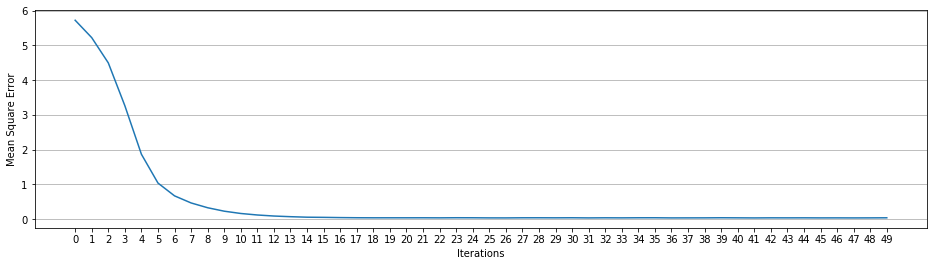

In [7]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")